In [ ]:
!pip install --upgrade git+https://github.com/huggingface/transformers.git

  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-n29jvy2g
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-n29jvy2g
  Resolved https://github.com/huggingface/transformers.git to commit bc8b0b0541b80be88d930a9ed375f0de2bc73a59
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.0/515.0 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 1.8 MB/s eta 0:00:00
  Created wheel for transformers: filename=transformers-5.0.0.dev0-py3-none-any.whl size=11353999 sha256=66002dc881d1d7832da8a3c7e9305db0f30b56025396a8bbccb187f02b551fcb
  Stored in directory: /tmp/pip-ephem-wheel-cache-thumfqer/wheels/54/cb/3f/83103de5575c534436d6a4686686dead458238dfaf1147e98d
Successfully built transformers
  Attempting uninstall: huggingface-hub
    Found

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device: ", device)

device:  cpu


In [ ]:
from transformers import AutoTokenizer, AutoModel
MODEL_NAME = "InstaDeepAI/nucleotide-transformer-500m-human-ref"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)
model = AutoModel.from_pretrained(MODEL_NAME, trust_remote_code=True).to(device)

# model = AutoModelForMaskedLM.from_pretrained(MODEL_NAME)

print("Model:", MODEL_NAME, "loaded succesfully!")


tokenizer_config.json:   0%|          | 0.00/129 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/101 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/706 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.94G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.94G [00:00<?, ?B/s]

Some weights of EsmModel were not initialized from the model checkpoint at InstaDeepAI/nucleotide-transformer-500m-human-ref and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: InstaDeepAI/nucleotide-transformer-500m-human-ref loaded succesfully!


In [ ]:
!pip install biopython

In [ ]:
import requests

# Fetch real sequence from UCSC
# TP53 promoter (~1kb upstream of TSS)

def fetch_sequence_ucsc(genome="hg38", chrom="chr17", start=7676150, end=7677150):
    """
    Fetches DNA sequence from UCSC REST API.
    genome: string, e.g., "hg38"
    chrom: chromosome, e.g., "chr17"
    start, end: 0‑based start to end (end excluded)
    Returns: string of bases (A/C/G/T/N)
    """
    url = "https://api.genome.ucsc.edu/getData/sequence"
    params = {
        "genome": genome,
        "chrom": chrom,
        "start": start,
        "end": end
    }
    r = requests.get(url, params=params)
    r.raise_for_status()
    data = r.json()
    return data["dna"]

# Example: get ~1kb region upstream of TSS of TP53 (chromosome 17)
tp53_promoter = fetch_sequence_ucsc()
print("Fetched sequence length:", len(tp53_promoter))
print(tp53_promoter[:100], "...", tp53_promoter[-100:])

Fetched sequence length: 1000
ACGGGGGGAGCAGCCTCTGGCATTCTGGGAGCTTCATCTGGACCTGGGTCTTCAGTGAACCATTGTTCAATATCGTCCGGGGACAGCATCAAATCATCCA ... ctcagtctcccgagtagctgggattacaggcgagtaccaccacacccagctaatttttgtatttttagtagagacagggctttgcatgttggccaggctg


In [ ]:
# Converts DNA strings -> token IDs, pads to max_length so the batch has uniform size.
# Returns a PyTorch tensor.

inputs = tokenizer(tp53_promoter, return_tensors="pt", truncation=True, max_length=1024)
inputs = {k:v.to(device) for k,v in inputs.items()}

# truncation=True ensures sequences longer than 1024 are truncated.
# {k:v.to(device)} moves tensors to GPU if available.

In [ ]:
with torch.no_grad():
    outputs = model(**inputs, output_hidden_states=True)

In [ ]:
# Compute sequence embedding by mean pooling
last_hidden_state = outputs.last_hidden_state  # shape: (1, seq_len, hidden_dim)
embedding = last_hidden_state.mean(dim=1).cpu().numpy().squeeze()

In [ ]:
genes = {
    "TP53": ("chr17", 7676150, 7677150),
    "MYC": ("chr8", 128748315, 128749315),
    "EGFR": ("chr7", 55019017, 55020017)
}

import requests

def fetch_sequence_ucsc(genome="hg38", chrom="chr17", start=0, end=1000):
    url = "https://api.genome.ucsc.edu/getData/sequence"
    params = {"genome": genome, "chrom": chrom, "start": start, "end": end}
    r = requests.get(url, params=params)
    r.raise_for_status()
    return r.json()["dna"]

sequences = []
names = []
for gene, (chrom, start, end) in genes.items():
    seq = fetch_sequence_ucsc(chrom=chrom, start=start, end=end)
    sequences.append(seq)
    names.append(gene)

In [ ]:
embeddings_list = []

for seq in sequences:
    inputs = tokenizer(seq, return_tensors="pt", truncation=True, max_length=1024)
    inputs = {k:v.to(device) for k,v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
    last_hidden_state = outputs.last_hidden_state  # (1, seq_len, hidden_dim)
    embedding = last_hidden_state.mean(dim=1).cpu().numpy().squeeze()
    embeddings_list.append(embedding)


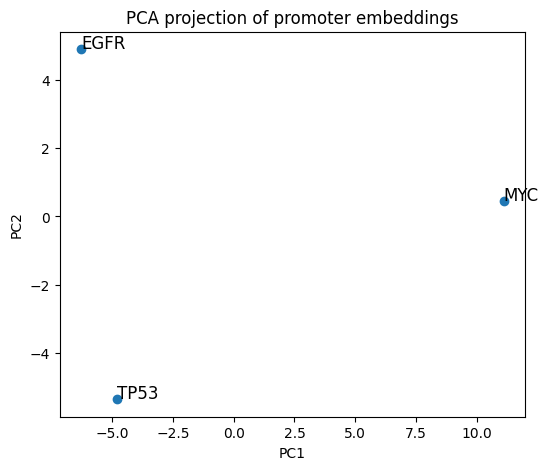

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Convert list to array
import numpy as np
X = np.stack(embeddings_list)  # shape: (num_sequences, embedding_dim)

# PCA to 2D
pca = PCA(n_components=2)
proj = pca.fit_transform(X)

# Scatter plot
plt.figure(figsize=(6,5))
plt.scatter(proj[:,0], proj[:,1])

# Add labels
for i, name in enumerate(names):
    plt.text(proj[i,0]+0.01, proj[i,1]+0.01, name, fontsize=12)

plt.title("PCA projection of promoter embeddings")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [ ]:
# Sample code from huggingface: https://huggingface.co/InstaDeepAI/nucleotide-transformer-500m-1000g

# # Choose the length to which the input sequences are padded. By default, the
# # model max length is chosen, but feel free to decrease it as the time taken to
# # obtain the embeddings increases significantly with it.
# max_length = tokenizer.model_max_length

# # Create a dummy dna sequence and tokenize it
# sequences = ["ATTCCGATTCCGATTCCG", "ATTTCTCTCTCTCTCTGAGATCGATCGATCGAT"]
# tokens_ids = tokenizer.batch_encode_plus(sequences, return_tensors="pt", padding="max_length", max_length = max_length)["input_ids"]

# # Compute the embeddings
# attention_mask = tokens_ids != tokenizer.pad_token_id
# torch_outs = model(
#     tokens_ids,
#     attention_mask=attention_mask,
#     encoder_attention_mask=attention_mask,
#     output_hidden_states=True
# )

# # Compute sequences embeddings
# embeddings = torch_outs['hidden_states'][-1].detach().numpy()
# print(f"Embeddings shape: {embeddings.shape}")
# print(f"Embeddings per token: {embeddings}")

# # Add embed dimension axis
# attention_mask = torch.unsqueeze(attention_mask, dim=-1)

# # Compute mean embeddings per sequence
# mean_sequence_embeddings = torch.sum(attention_mask*embeddings, axis=-2)/torch.sum(attention_mask, axis=1)
# print(f"Mean sequence embeddings: {mean_sequence_embeddings}")

KeyboardInterrupt: 